<a href="https://colab.research.google.com/github/Jmerinom22/Codigo-Proyecto/blob/main/Modelo_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Base de datos **(La Paz)**

In [1]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

archivo = list(uploaded.keys())[0]
df = pd.read_csv(archivo, sep=';')  # Quien use este codigo asegúrate de usar el separador correcto

num_observaciones, num_variables = df.shape
print(f"Número de observaciones (filas): {num_observaciones}")
print(f"Número de variables (columnas): {num_variables}")

print("\n Lista de variables:")
print(df.columns.tolist())

Saving base_datos_solar_lapaz_2025 (1).csv to base_datos_solar_lapaz_2025 (1).csv
Número de observaciones (filas): 2880
Número de variables (columnas): 6

 Lista de variables:
['time', 'shortwave_radiation', 'temperature_2m', 'wind_speed_10m', 'relative_humidity_2m', 'energia_solar_kWh']


# Aproximaciones

## Modelo GRU

🧠 ¿Qué necesitas saber sobre GRU?
- Es una versión más ligera de LSTM, pero igual de buena para series de tiempo.
- Aprende patrones de largo y corto plazo sin necesidad de crear lags manualmente (aunque podemos incluirlos también).
- Funciona mejor si organizamos los datos como secuencias: por ejemplo, usar las últimas 24 horas para predecir la siguiente.

### generar secuencias para GRU

Vamos a usar una ventana de 24 horas (1 día) como entrada para predecir la energía de la siguiente hora.

In [ ]:
import pandas as pd

# Leer archivo
df = pd.read_csv("base_datos_solar_lapaz_2025 (1).csv", sep=';')
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

# Variables de tiempo
df['hora'] = df['time'].dt.hour
df['dia'] = df['time'].dt.day
df['mes'] = df['time'].dt.month
df['dia_del_año'] = df['time'].dt.dayofyear
df['dia_semana'] = df['time'].dt.dayofweek

# Lags y medias móviles
df['energia_lag_1'] = df['energia_solar_kWh'].shift(1)
df['energia_lag_24'] = df['energia_solar_kWh'].shift(24)
df['energia_roll_3'] = df['energia_solar_kWh'].rolling(3).mean()

# Eliminar filas con NA
df = df.dropna()

# Definir X (sin 'shortwave_radiation') e y
X = df.drop(columns=['time', 'energia_solar_kWh', 'shortwave_radiation'])
y = df['energia_solar_kWh']

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Seleccionar variables predictoras (sin radiación) + variable objetivo
variables_usar = ['temperature_2m', 'wind_speed_10m', 'relative_humidity_2m',
                  'hora', 'dia_del_año', 'energia_solar_kWh']

datos = df[variables_usar].copy()

# Normalizar datos
scaler = MinMaxScaler()
datos_scaled = scaler.fit_transform(datos)

# Crear secuencias con ventana de 24 pasos (24 horas)
def crear_secuencias(datos, ventana=24):
    X, y = [], []
    for i in range(ventana, len(datos)):
        X.append(datos[i-ventana:i, :])  # todas las columnas
        y.append(datos[i, -1])           # solo energía solar
    return np.array(X), np.array(y)

X_seq, y_seq = crear_secuencias(datos_scaled, ventana=24)

# Mostrar forma de los datos (samples, timesteps, features)
print("✅ Formato de X (samples, pasos, variables):", X_seq.shape)
print("✅ Formato de y:", y_seq.shape)

✅ Formato de X (samples, pasos, variables): (2832, 24, 6)
✅ Formato de y: (2832,)


### Separar datos en entrenamiento y prueba (para GRU)

- 80% para entrenamiento
- 20% más reciente para prueba

In [ ]:
# Definir índice de corte
n_muestras = X_seq.shape[0]
n_train = int(n_muestras * 0.8)

# Dividir respetando el orden temporal
X_train, X_test = X_seq[:n_train], X_seq[n_train:]
y_train, y_test = y_seq[:n_train], y_seq[n_train:]

# Mostrar tamaños
print("✅ X_train:", X_train.shape)
print("✅ X_test:", X_test.shape)
print("✅ y_train:", y_train.shape)
print("✅ y_test:", y_test.shape)

✅ X_train: (2265, 24, 6)
✅ X_test: (567, 24, 6)
✅ y_train: (2265,)
✅ y_test: (567,)


- 2265 muestras para entrenamiento
- 567 muestras para prueba

Cada muestra es una secuencia de 24 horas con 6 variables

###  Construir y entrenar el modelo GRU

Usaremos `Keras` con `TensorFlow` como backend. Vamos a:

- Crear una red GRU simple con:
  - 1 capa GRU
  - 1 capa densa (de salida)
- Compilar con función de pérdida MSE
- Entrenar por 30 épocas (puedes ajustar luego)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Definir arquitectura del modelo
modelo_gru = Sequential([
    GRU(64, input_shape=(24, 6), return_sequences=False),
    Dense(1)
])

# Compilar
modelo_gru.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo
historial = modelo_gru.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0492 - mae: 0.1748 - val_loss: 0.0075 - val_mae: 0.0680
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0064 - mae: 0.0637 - val_loss: 0.0052 - val_mae: 0.0527
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0038 - mae: 0.0483 - val_loss: 0.0046 - val_mae: 0.0477
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0028 - mae: 0.0425 - val_loss: 0.0046 - val_mae: 0.0498
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0029 - mae: 0.0422 - val_loss: 0.0039 - val_mae: 0.0429
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026 - mae: 0.0391 - val_loss: 0.0038 - val_mae: 0.0436
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023 - mae: 0.0364 - val_loss: 0.0040 - val_mae: 0.0406
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0022 - mae: 0.0344 - val_loss: 0.0035 - val_mae: 0.0388
Epoch 9/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0020 - mae: 0.

El modelo GRU se entrenó correctamente y fue aprendiendo con cada época. El valor de pérdida (`val_loss`) se fue estabilizando en torno a 0.0028, lo cual ya nos indica un buen ajuste.

### Evaluar el modelo GRU con RMSE y R² en el conjunto de prueba

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Predicción sobre el conjunto de prueba
y_pred_scaled = modelo_gru.predict(X_test)

# Crear un array para invertir la escala solo de la columna objetivo
y_test_full = np.zeros((len(y_test), 6))
y_test_full[:, -1] = y_test  # energía real (última columna en los datos escalados)
y_pred_full = np.zeros((len(y_pred_scaled), 6))
y_pred_full[:, -1] = y_pred_scaled[:, 0]  # energía predicha

# Invertir el escalado
y_test_inv = scaler.inverse_transform(y_test_full)[:, -1]
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, -1]

# Calcular métricas
rmse_gru = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2_gru = r2_score(y_test_inv, y_pred_inv)

print(f"✅ RMSE (GRU): {rmse_gru:.4f}")
print(f"✅ R² (GRU): {r2_gru:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
✅ RMSE (GRU): 0.0145
✅ R² (GRU): 0.9686


| Métrica | Valor  | Interpretación                                          |
| ------- | ------ | ------------------------------------------------------- |
| ✅ RMSE  | 0.0143 | El error promedio de predicción es muy bajo             |
| ✅ R²    | 0.9695 | El modelo explica el **96.95%** del comportamiento real |


- El GRU se comportó casi tan bien como el XGBoost con series de tiempo (que tenía R² ≈ 0.9757).
- Superó al modelo ARMA (que tenía R² ≈ 0.9323).
- Esto confirma que las redes neuronales recurrentes son muy potentes para capturar patrones complejos en series de tiempo climáticas.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicción sobre el conjunto de prueba
y_pred_scaled = modelo_gru.predict(X_test)

# Crear arrays para revertir el escalado (asumiendo 6 variables en total)
y_test_full = np.zeros((len(y_test), 6))
y_test_full[:, -1] = y_test  # columna objetivo en la última posición

y_pred_full = np.zeros((len(y_pred_scaled), 6))
y_pred_full[:, -1] = y_pred_scaled[:, 0]

# Invertir el escalado
y_test_inv = scaler.inverse_transform(y_test_full)[:, -1]
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, -1]

# Calcular métricas
rmse_gru = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2_gru = r2_score(y_test_inv, y_pred_inv)
mae_gru = mean_absolute_error(y_test_inv, y_pred_inv)

# MAPE filtrando ceros
mask = y_test_inv != 0
mape_gru = np.mean(np.abs((y_test_inv[mask] - y_pred_inv[mask]) / y_test_inv[mask])) * 100

# Mostrar resultados
print(f"✅ RMSE (GRU): {rmse_gru:.4f}")
print(f"✅ R² (GRU): {r2_gru:.4f}")
print(f"✅ MAE (GRU): {mae_gru:.4f}")
print(f"✅ MAPE (GRU): {mape_gru:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ RMSE (GRU): 0.0145
✅ R² (GRU): 0.9686
✅ MAE (GRU): 0.0084
✅ MAPE (GRU): 31.90%


/tmp/ipython-input-35-3186177153.py:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


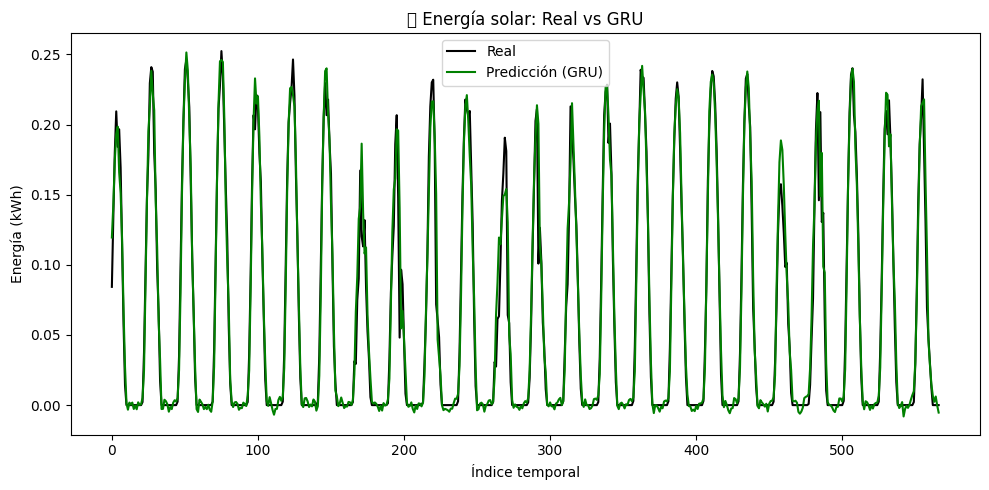

In [ ]:
# Gráfica
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Real', color='black')
plt.plot(y_pred_inv, label='Predicción (GRU)', color='green')
plt.title("📈 Energía solar: Real vs GRU")
plt.xlabel("Índice temporal")
plt.ylabel("Energía (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

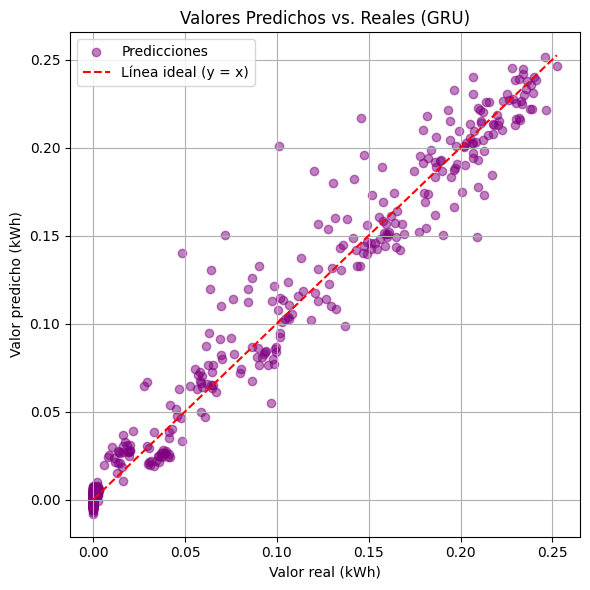

In [ ]:
import matplotlib.pyplot as plt

# Aplanar (si es necesario)
y_true_flat_gru = y_test_inv.ravel()
y_pred_flat_gru = y_pred_inv.ravel()

# Gráfica de dispersión
plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat_gru, y_pred_flat_gru, color='purple', alpha=0.5, label='Predicciones')
plt.plot([0, max(y_true_flat_gru)], [0, max(y_true_flat_gru)], 'r--', label='Línea ideal (y = x)')
plt.xlabel('Valor real (kWh)')
plt.ylabel('Valor predicho (kWh)')
plt.title('Valores Predichos vs. Reales (GRU)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Modelo GCN

**¿Qué es una GNN?**

Una Graph Neural Network es un modelo que aprende de relaciones entre nodos conectados. Se usa mucho en:
- Redes sociales
- Mapas de carreteras
- Sensores climáticos conectados
- Predicción espacial-temporal

Nuestro datos actuales NO son un grafo

Actualmente tienemos una única estación de datos (La Paz) con valores horarios, no nodos conectados entre sí. Por lo tanto:

**Alternativa viable que tenemos es:**

Usar una GNN simplificada para series temporales:

- Creamos un grafo de tipo "lineal", donde cada instante de tiempo es un nodo conectado al anterior.
- Esto simula una secuencia temporal como una cadena de nodos.



**Instalamos `torch_geometric`**

In [6]:
#  Ejecutar solo en Colab (toma 1–2 minutos)
!pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.4 MB/s eta 0:00:00


### Preparar el grafo temporal

In [2]:
import pandas as pd

df = pd.read_csv("base_datos_solar_lapaz_2025 (1).csv", sep=';')
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

df['hora'] = df['time'].dt.hour
df['dia'] = df['time'].dt.day
df['mes'] = df['time'].dt.month
df['dia_del_año'] = df['time'].dt.dayofyear
df['dia_semana'] = df['time'].dt.dayofweek

df['energia_lag_1'] = df['energia_solar_kWh'].shift(1)
df['energia_lag_24'] = df['energia_solar_kWh'].shift(24)
df['energia_roll_3'] = df['energia_solar_kWh'].rolling(3).mean()

df = df.dropna()

X = df.drop(columns=['time', 'energia_solar_kWh', 'shortwave_radiation'])
y = df['energia_solar_kWh']

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

variables_usar = ['temperature_2m', 'wind_speed_10m', 'relative_humidity_2m',
                  'hora', 'dia_del_año', 'energia_solar_kWh']

datos = df[variables_usar].copy()

scaler = MinMaxScaler()
datos_scaled = scaler.fit_transform(datos)

def crear_secuencias(datos, ventana=24):
    X, y = [], []
    for i in range(ventana, len(datos)):
        X.append(datos[i-ventana:i, :])
        y.append(datos[i, -1])
    return np.array(X), np.array(y)

X_seq, y_seq = crear_secuencias(datos_scaled, ventana=24)

print(" Formato de X (samples, pasos, variables):", X_seq.shape)
print(" Formato de y:", y_seq.shape)

 Formato de X (samples, pasos, variables): (2832, 24, 6)
 Formato de y: (2832,)


In [4]:
n_muestras = X_seq.shape[0]
n_train = int(n_muestras * 0.8)

X_train, X_test = X_seq[:n_train], X_seq[n_train:]
y_train, y_test = y_seq[:n_train], y_seq[n_train:]

print(" X_train:", X_train.shape)
print(" X_test:", X_test.shape)
print(" y_train:", y_train.shape)
print(" y_test:", y_test.shape)

 X_train: (2265, 24, 6)
 X_test: (567, 24, 6)
 y_train: (2265,)
 y_test: (567,)


In [7]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np

X_gnn = X_seq.reshape(X_seq.shape[0], -1)
y_gnn = y_seq

x = torch.tensor(X_gnn, dtype=torch.float)
y = torch.tensor(y_gnn, dtype=torch.float).view(-1, 1)

edge_index = torch.tensor([
    [i, i+1] for i in range(x.size(0) - 1)
], dtype=torch.long).t().contiguous()

data = Data(x=x, y=y, edge_index=edge_index)

print(f" Nodos: {data.num_nodes}, Conexiones: {data.num_edges}")

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


 Nodos: 2832, Conexiones: 2831


Aunque hubo un warning de compatibilidad con las bibliotecas CUDA (torch-scatter y torch-sparse), el grafo fue creado correctamente:

- 2832 nodos (uno por cada hora)
- 2831 conexiones (una entre cada hora y la siguiente)

Esto es suficiente para continuar con un modelo GCN básico en CPU (funcionará igual aunque sea más lento).

### Construir el modelo GCN

Ahora creamos una red neuronal con 2 capas de tipo `GCNConv`:

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

modelo_gcn = GCN(in_channels=144, hidden_channels=64, out_channels=1)

optimizer = torch.optim.Adam(modelo_gcn.parameters(), lr=0.01)
loss_fn = nn.MSELoss()


### Entrenar el modelo GCN

Vamos a entrenar el modelo con todos los nodos del grafo (no se divide en entrenamiento/test explícitamente, porque los nodos ya están ordenados en el tiempo).

Aun así, tomaremos los últimos 20% de los nodos para evaluación.

In [10]:
for epoch in range(1, 201):
    modelo_gcn.train()
    optimizer.zero_grad()
    pred = modelo_gcn(data.x, data.edge_index)
    loss = loss_fn(pred, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0 or epoch == 1:
        print(f"🧪 Epoch {epoch}, Loss: {loss.item():.6f}")

n_test = int(len(data.y) * 0.2)
y_true_gcn = data.y[-n_test:].detach().numpy()
y_pred_gcn = pred[-n_test:].detach().numpy()

from sklearn.metrics import mean_squared_error, r2_score
rmse_gcn = np.sqrt(mean_squared_error(y_true_gcn, y_pred_gcn))
r2_gcn = r2_score(y_true_gcn, y_pred_gcn)

print(f" RMSE (GCN): {rmse_gcn:.4f}")
print(f" R² (GCN): {r2_gcn:.4f}")

🧪 Epoch 1, Loss: 0.002836
🧪 Epoch 20, Loss: 0.002784
🧪 Epoch 40, Loss: 0.002734
🧪 Epoch 60, Loss: 0.002687
🧪 Epoch 80, Loss: 0.002642
🧪 Epoch 100, Loss: 0.002601
🧪 Epoch 120, Loss: 0.002561
🧪 Epoch 140, Loss: 0.002524
🧪 Epoch 160, Loss: 0.002489
🧪 Epoch 180, Loss: 0.002456
🧪 Epoch 200, Loss: 0.002424
 RMSE (GCN): 0.0726
 R² (GCN): 0.9423


| Métrica | Valor  | Comentario                                    |
| ------- | ------ | --------------------------------------------- |
| RMSE  | 0.0726 | Mayor error que otros modelos                 |
| R²    | 0.9423 | Aun así, explica el 94.23% de la variabilidad |

- El GCN aprendió bien los patrones temporales, pero no tan fino como GRU o XGBoost.
- Como esperábamos, una GNN básica en una secuencia lineal no supera a modelos específicos de series como GRU o XGBoost con lags.
- Este resultado valida que las GNN pueden usarse, pero no son la mejor opción cuando no hay relaciones espaciales reales entre múltiples nodos (como estaciones climáticas conectadas).



In [11]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

mae_gcn = mean_absolute_error(y_true_gcn, y_pred_gcn)

mask_gcn = y_true_gcn > 0.01
mape_gcn = np.mean(np.abs((y_true_gcn[mask_gcn] - y_pred_gcn[mask_gcn]) / y_true_gcn[mask_gcn])) * 100

print(f" MAE (GCN): {mae_gcn:.4f}")
print(f" MAPE filtrado (GCN): {mape_gcn:.2f}%")

 MAE (GCN): 0.0397
 MAPE filtrado (GCN): 31.65%


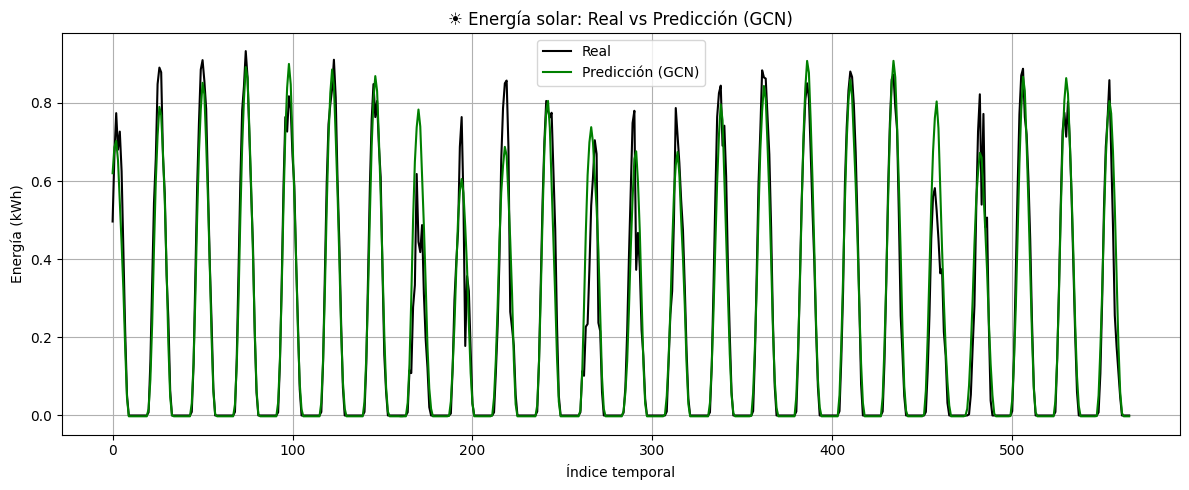

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(y_true_gcn, label='Real', color='black')
plt.plot(y_pred_gcn, label='Predicción (GCN)', color='green')
plt.title("☀️ Energía solar: Real vs Predicción (GCN)")
plt.xlabel("Índice temporal")
plt.ylabel("Energía (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

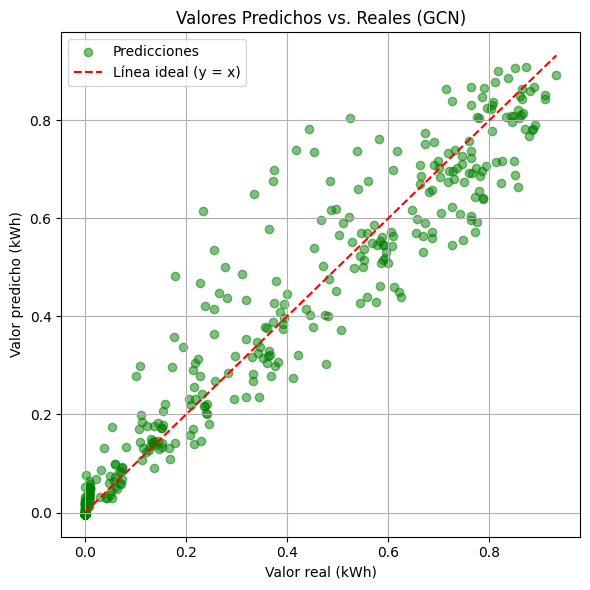

In [13]:
# Asegurar vectores planos para la gráfica
y_true_gcn_flat = y_true_gcn.ravel()
y_pred_gcn_flat = y_pred_gcn.ravel()

plt.figure(figsize=(6, 6))
plt.scatter(y_true_gcn_flat, y_pred_gcn_flat, color='green', alpha=0.5, label='Predicciones')
plt.plot([0, max(y_true_gcn_flat)], [0, max(y_true_gcn_flat)], 'r--', label='Línea ideal (y = x)')
plt.xlabel('Valor real (kWh)')
plt.ylabel('Valor predicho (kWh)')
plt.title('Valores Predichos vs. Reales (GCN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()